In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25) 
from scipy.interpolate import interp1d
from scholte import *
import pickle
import cmasher as cmr

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
kobs,fobs=load_dispersion_observations()

'''
Define the inital model
'''
h =  [0.100, 0.005, 0.010, 0.02, 0.02, 0.02, 0.02,  0.0]
vs = np.array([0, 0.0233, 0.0522, 0.0906, 0.125 , 0.20 , 0.25,  1.5])
vp = np.ones_like(vs) * 1.6
vp[0]=1.5
rho = np.ones_like(vs) * 1.5
rho[0]=1
z = np.hstack([0,np.cumsum(h)*1e3,1000])
vs_input = 1000*np.hstack([vs,vs[-1],vs[-1]])/1e3
f,k = pysurf96(h,vp,vs,rho)


'''
State the old model (tuned on one mode)
'''
h1 =  np.hstack([0,np.array([0.100, 0.005, 0.010, 0.025, 0.0])*1000,300])
vs1 = [0,0, 0.038, 0.043, 0.080, 0.600,0.6]
z1 = np.hstack([0,np.cumsum(h1),1000])
vs1_input = 1000*np.hstack([vs1,vs1[-1],vs1[-1]])

In [3]:
filename = 'three-modes-small.pickle'

DoMoreIterations = False

if DoMoreIterations:
    for restartnumber in range(9):
        do_mcmc(kobs,fobs, h, vs, N = 100, 
                filename=filename,
                restartfile=filename,
                step_size = 1e-3,
                f_sensitivity = 0.005,
                verbose=False)


x = pickle.load(open(filename, 'rb'))
n = x.shape[0]
y = x[int(n/3):,:]
ymean = np.mean(y,axis=0)

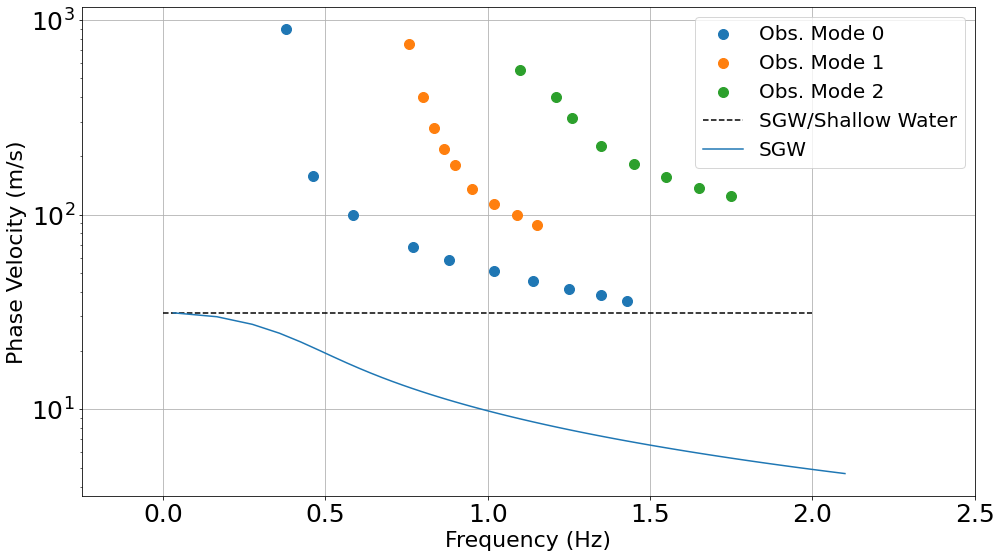

In [50]:
'''
Plot the data
'''
fig,ax=plt.subplots(figsize=(16,9))
for kk,ff,ind in zip(kobs,fobs,range(len(kobs))):
    ax.scatter( ff , ff/kk, c=f'C{ind}' , label=f'Obs. Mode {ind}',s=100, zorder=10)

newk = np.linspace(1e-3,0.45,100)
plt.plot((0,2),np.sqrt(9.8*100)*np.array((1,1)),'--k',label='SGW/Shallow Water')
ax.plot   ( np.sqrt(9.8*newk*np.tanh(newk*100)) , np.sqrt(9.8*newk*np.tanh(newk*100))/newk,label='SGW')
plt.yscale('log')
plt.xlabel('Frequency (Hz)',fontsize=22)
plt.ylabel('Phase Velocity (m/s)',fontsize=22)
plt.legend(fontsize=20)
plt.grid()
plt.xlim([-0.25,2.5])
plt.savefig('sgw-sch.png')
plt.show()

KeyboardInterrupt: 

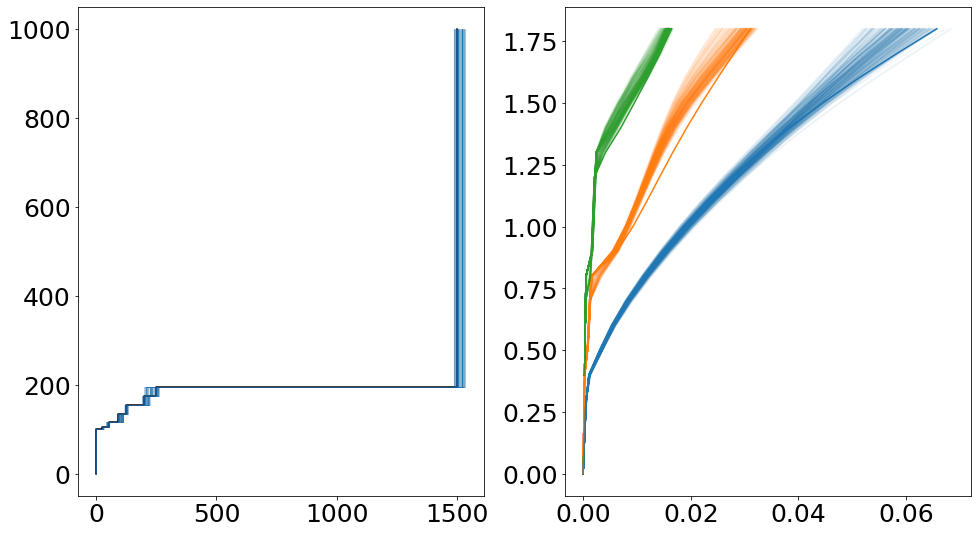

In [4]:
fig,ax=plt.subplots(1,2,figsize=(16,9))
fig.patch.set_facecolor('w')

shuffle = np.linspace(0,y.shape[0]-1).astype(int)
shuffle = np.random.shuffle(shuffle)

'''
Plot the initial model
'''
ax[0].plot(0,c='C0',linewidth=0.5,label='MCMC Iterations')
ax[0].step(vs_input*1e3,z,'-k',label='Model calibrated from three modes')

'''
Plot the initial dispersion curves
'''
for kk,ff,ind in zip(k,f,range(len(k))):
    ax[1].plot(kk,ff,'-',label=f'Model Mode {ind}',markersize=12,c=f'C{ind}')

'''
Plot the MCMC VS model
'''
for j,xx in enumerate(y[shuffle,:].squeeze()):
    this_vs = np.hstack([xx,xx[-1],xx[-1]])
    ax[0].step(this_vs, z, c='C0',alpha=0.05,linewidth=0.5)
    
'''
Plot the MCMC dispersion curves
'''
for j,xx in enumerate(y[shuffle,:].squeeze()):
    vs_input = np.hstack([xx,xx[-1],xx[-1]])/1e3
    f,k = pysurf96(h,vp,vs_input,rho)
    for kk,ff,ind in zip(k,f,range(len(k))):
        ax[1].plot(kk,ff,markersize=12,c=f'C{ind}',alpha=0.05)
    
ax[0].step(vs1_input,z1,'--',c='grey',label='model calibrated from one mode')

'''
Plot the data
'''
for kk,ff,ind in zip(kobs,fobs,range(len(kobs))):
    ax[1].scatter( kk , ff, c='k' , label=f'Obs. Mode {ind}',s=100, zorder=10)

ax[1].set_ylabel('Frequency (Hz)',fontsize=25)
ax[1].set_xlabel(r'Ordinary Wavenumber, (1/m)',fontsize=25)


ax[0].set_ylim([300,0])
ax[0].grid()
ax[0].set_ylabel('Depth (m)',fontsize=22)
ax[0].set_xlabel('Shear Wave Speed (m/s)',fontsize=22)
ax[0].set_xlim([-10, 1600])


XX,YY = np.meshgrid(np.linspace(0,2000,100),np.linspace(0,300,200))
ZZ = np.zeros_like(YY)
for zz,vv in zip(z[-1:0:-1],vs_input[-2::-1]):
    ZZ[YY<zz] = vv

# Access rainforest colormap through CMasher or MPL
# cmap = cmr.rainforest                   # CMasher
# cmap = plt.get_cmap('cmr.sunburst_r')   # MPL
# c=ax[0].pcolor(XX,YY,ZZ*1e3,cmap=cmap,vmin=0,vmax=3000)
# cb=fig.colorbar(c,location='bottom',ax=ax[0],shrink=0.6)
# cb.set_label('Shear Wave Speed',fontsize=25)

ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)
ax[1].grid()
ax[0].set_title('A. Shear wave speed model',fontsize=25)
ax[1].set_title('B. Dispersion curves',fontsize=25)
plt.tight_layout()
plt.savefig('model.png')
plt.show()

In [5]:
z = np.hstack([0,np.cumsum(h0)*1000,500])
mean_vs = np.hstack([0,ymean,ymean[-1],ymean[-1]])

one_mode_vs = np.array(v1)*1000
one_mode_z = np.cumsum(h1)

NameError: name 'h0' is not defined

In [ ]:
# set up the initial velocity model
vp = np.ones_like(vs0) * 1.6
vp[0]=1.5
rho = np.ones_like(vs0) * 1.5
rho[0]=1

In [ ]:
print(ymean/1e3)
print(vs0)

In [ ]:
np.hstack([0,x[0]])

In [ ]:
y_mean = np.mean(y[:,8:],axis=0)
y_std  = np.std(y[:,8:],axis=0)
percent_change_from_initial_guess = (y_mean/1e3 - vs0)/vs0*100
percent_change_from_initial_guess

In [ ]:
np.round(y_mean/1000,4)

In [ ]:
fig,ax=plt.subplots()
fig.patch.set_facecolor('w')


def weighted_average(x):
    weighted_avg = 0
    thickness = 0

    n = 6
    for i in range(n):
        weighted_avg = weighted_avg + x[:,8+i]*x[:,1+i]
        thickness = thickness + x[0,1+i]
    return weighted_avg / thickness

wavg = weighted_average(x)
plt.plot( wavg ) 

m = []
s = []
for i in range(x[:,8].shape[0]):
    m.append( np.mean(wavg[0:i]))
    v = 0
    for j in range(8,15):
        v = np.var(wavg[0:i]) + v
    s.append(np.sqrt(v))
m = np.array(m)
s = np.array(s)
plt.plot(m)
plt.plot(m+s)
plt.plot(m-s)